In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import matplotlib as mpl

from colors import colors
from utils import expected_interaction_rate

%config InlineBackend.figure_formats = ['svg']
mpl.rcParams.update({'font.size': 12})

In [28]:
# Fig 2a (data comparison phonon; example signal spectral overlaid for comparison)
# data:
# energy:
# - HVeV: R3 / (non)-burst; HO confirming data?
# - CRESST: see plot with various materials
# - SPICE:
# - EDELWEISS: Roger will send email
# - BULLKID: Felix; they might have an update
# - NuCLEUS

# time:
# - CRESST
# - SPICE
# - EDELWEISS: ask for PhD thesis content (Emeline Queguiner: https://theses.hal.science/tel-02025002)
# - Qubit: Felix; need to see whether it makes sense on plot

# Fig 2b (data comparison charge; dark rate inset? redundant w/ Fig 5; example signal spectra overlaid for comparison)
# time (single e rate / g / day over arXiv date):
# - RICOCHET: Roger was in contact with Scott; will check again with him about data. Dan will also check with Tali about potentially unpublished data that might be included
# - SENSEI: maybe for DCR inset / or own plot on DCR over time (years)?
# - HVeV
# - EDELWEISS
# - DAMIC SNOLAB
# - DAMIC-M


# fig 5 (Comparison of different experiment dark rates w/ thermal predictions for different temperatures)
# -> merge this thought into 2b e.g. by lines for thermal predictions

# get data

In [29]:
def random_power(a, b, c, size):
    r = np.random.random(size=size)
    return ( a ** c + ( b ** c - a ** c ) * r ) ** ( 1. / c )

In [30]:
# spectra from phonon experiments 

# TODO replace with real data 
# TODO choice of experiments below is just an example

In [31]:
data = {}
data['bins'] = np.logspace(np.log10(5),np.log10(1100),50)  # eV # TODO replace
data['bw'] = data['bins'][1:] - data['bins'][:-1]  # bin width
data['bc'] = data['bins'][:-1] + data['bw'] / 2. # bin centers 
bwint = interpolate.interp1d(data['bins'][1:], data['bw'], kind='next') 
data['grid'] = np.logspace(np.log10(data['bins'][0]), np.log10(data['bins'][-1]), 10000)

# CRESST (to be replaced) 

expr = 'cresst'
data[expr] = {}

data[expr]['exposure'] = 1.  # kg days # TODO replace
data[expr]['threshold'] = 30.  # eV # TODO replace
data[expr]['recoils'] = np.random.uniform(data[expr]['threshold'], data['bins'][-1], 10) # TODO replace
data[expr]['recoils'] = np.concatenate((data[expr]['recoils'], random_power(data[expr]['threshold'], data['bins'][-1], -1, 1000))) # TODO replace
data[expr]['hist'], _ = np.histogram(data[expr]['recoils'], data['bins'], 
                                      weights=np.ones(len(data[expr]['recoils']))/bwint(data[expr]['recoils'])/data[expr]['exposure'])

# BULLKID (to be replaced) 

expr = 'bullkid'
data[expr] = {}

data[expr]['exposure'] = 1.  # kg days # TODO replace
data[expr]['threshold'] = 150.  # eV # TODO replace
data[expr]['recoils'] = np.random.uniform(data[expr]['threshold'], data['bins'][-1], 1000000) # TODO replace
# data[expr]['recoils'] = np.concatenate((data[expr]['recoils'], random_power(data[expr]['threshold'], data['bins'][-1], -1, 200))) # TODO replace
data[expr]['hist'], _ = np.histogram(data[expr]['recoils'], data['bins'], 
                                      weights=np.ones(len(data[expr]['recoils']))/bwint(data[expr]['recoils'])/data[expr]['exposure'])

# CPD (to be replaced) 

expr = 'cpd'
data[expr] = {}

data[expr]['exposure'] = .1  # kg days # TODO replace
data[expr]['threshold'] = 25.  # eV # TODO replace
data[expr]['recoils'] = np.random.uniform(data[expr]['threshold'], data['bins'][-1], 1000) # TODO replace
data[expr]['recoils'] = np.concatenate((data[expr]['recoils'], random_power(data[expr]['threshold'], data['bins'][-1], -3, 10000))) # TODO replace
data[expr]['hist'], _ = np.histogram(data[expr]['recoils'], data['bins'], 
                                      weights=np.ones(len(data[expr]['recoils']))/bwint(data[expr]['recoils'])/data[expr]['exposure'])


In [32]:
# dark matter spectrum

In [33]:
crosssection = .01  # pb
dm_mass = 1.0  # GeV / c^2 
target_weight = 28.  # Si target

data['dmrate'] = crosssection * np.array([expected_interaction_rate(1e-3*e,  # keV
                                           dm_mass,  
                                           target_weight,  
                                          ) for e in data['grid']])
data['dmrate'] *= 1e-3 # convert to 1 / eV / kg / days 

In [34]:
# data dark rates 

# TODO replace with real data 

In [43]:
data_e = {}

# experiment 1 (to be replaced) 
expr = 'exp1'
data_e[expr] = {}

data_e[expr]['date'] = 100  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e4  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace

# experiment 1.2 (to be replaced) 
expr = 'exp2'
data_e[expr] = {}

data_e[expr]['date'] = 800  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e3  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace

# experiment 2 (to be replaced) 
expr = 'exp3'
data_e[expr] = {}

data_e[expr]['date'] = 300  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e2  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace

# experiment 2.1 (to be replaced) 
expr = 'exp4'
data_e[expr] = {}

data_e[expr]['date'] = 1000  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e1  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace

# experiment 2.2 (to be replaced) 
expr = 'exp5'
data_e[expr] = {}

data_e[expr]['date'] = 1800  # days since 2019 # TODO replace 
data_e[expr]['exposure'] = 0.01  # kg days # TODO replace 
data_e[expr]['rate'] = 1e0  # e- / days / g # TODO replace
data_e[expr]['uncertainty'] = np.sqrt(data_e[expr]['rate'] * data_e[expr]['exposure'])/data_e[expr]['exposure']  # e- / days / g # TODO replace


In [44]:
# thermal floor dark rate 

In [45]:
data_e['thermal'] = 1e-2

# plot

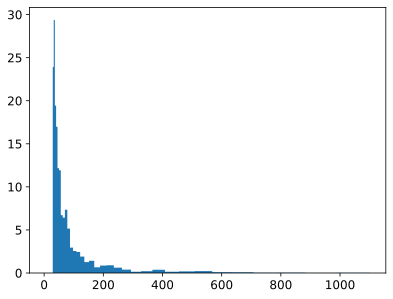

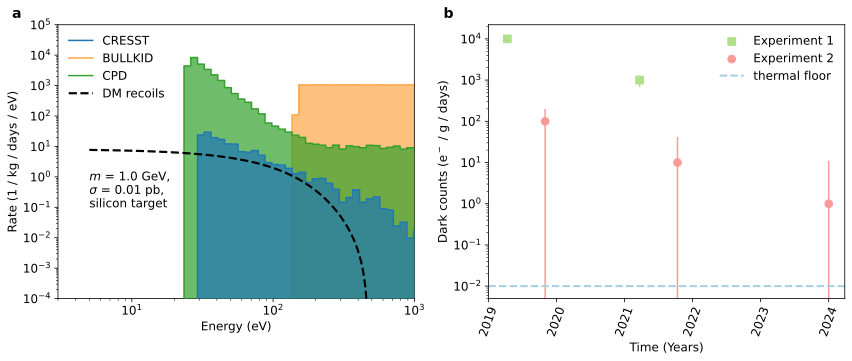

In [60]:
fig, ax = plt.subplots(1, 2, dpi=300, figsize=(12,5))

# ---------------------------------------------
# a
# ---------------------------------------------

# experiments
ax[0].stairs(data['cresst']['hist'], data['bins'], fill=True, 
             color=colors[1], alpha=0.7, zorder=5)
ax[0].stairs(data['bullkid']['hist'], data['bins'], fill=True, 
             color=colors[2], alpha=0.7, zorder=1)
ax[0].stairs(data['cpd']['hist'], data['bins'], fill=True, 
             color=colors[4], alpha=0.7, zorder=3)

ax[0].step(data['bc'], data['cresst']['hist'], where='mid', 
           color=colors[1], linewidth=1.5, label='CRESST', zorder=6)  # if no fill use linewith 2.2
ax[0].step(data['bc'], data['bullkid']['hist'], where='mid', 
           color=colors[2], linewidth=1.5, label='BULLKID', zorder=2)
ax[0].step(data['bc'], data['cpd']['hist'], where='mid', 
           color=colors[4], linewidth=1.5, label='CPD', zorder=4)

# dm spectrum
ax[0].plot(data['grid'], data['dmrate'], color='black', linewidth=2.2, linestyle='dashed', zorder=20, 
           label='DM recoils')
ax[0].text(5, .1, "$m$ = {:.2} GeV,\n$\sigma$ = {:.2} pb,\nsilicon target".format(dm_mass, crosssection))

# specs
fig.text(0.02, 0.97, 'a', size=14, weight='bold')
ax[0].legend(frameon=False, loc='upper left')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(3, 1000)
ax[0].set_ylim(1e-4, 1e5)
ax[0].set_ylabel('Rate (1 / kg / days / eV)')
ax[0].set_xlabel('Energy (eV)')

# ---------------------------------------------
# b
# ---------------------------------------------

# experiments

ax[1].scatter(data_e['exp1']['date'], data_e['exp1']['rate'],
              color=colors[3], s=60, marker='s', label='Experiment 1', )
ax[1].errorbar(data_e['exp1']['date'], data_e['exp1']['rate'], 
               yerr=data_e['exp1']['uncertainty'], #fmt="o", 
               color=colors[3],
              )

ax[1].scatter(data_e['exp2']['date'], data_e['exp2']['rate'],
              color=colors[3], s=60, marker='s')
ax[1].errorbar(data_e['exp2']['date'], data_e['exp2']['rate'], 
               yerr=data_e['exp2']['uncertainty'], #fmt="o",  
               color=colors[3],
              )

ax[1].scatter(data_e['exp3']['date'], data_e['exp3']['rate'],
              color=colors[5], s=60, label='Experiment 2')
ax[1].errorbar(data_e['exp3']['date'], data_e['exp3']['rate'], 
               yerr=data_e['exp3']['uncertainty'], #fmt="o", 
               color=colors[5],
              )

ax[1].scatter(data_e['exp4']['date'], data_e['exp4']['rate'],
              color=colors[5], s=60)
ax[1].errorbar(data_e['exp4']['date'], data_e['exp4']['rate'], 
               yerr=data_e['exp4']['uncertainty'], #fmt="o", 
               color=colors[5],
              )

ax[1].scatter(data_e['exp5']['date'], data_e['exp5']['rate'],
              color=colors[5], s=60)
ax[1].errorbar(data_e['exp5']['date'], data_e['exp5']['rate'], 
               yerr=data_e['exp5']['uncertainty'], #fmt="o", 
               color=colors[5],
              )

# thermal limits

ax[1].axhline(data_e['thermal'], color=colors[0], linewidth=2, linestyle='dashed',
              label='thermal floor')

# specs
fig.text(0.52, 0.97, 'b', size=14, weight='bold')
ax[1].legend(frameon=False, loc='upper right')
ax[1].set_xscale('linear')
ax[1].set_yscale('log')
# ax[1].set_xlim(0, 600)
# ax[1].set_ylim(1e-1, 1e5)
ax[1].set_ylabel('Dark counts (e$^-$ / g / days)')
ax[1].set_xlabel('Time (Years)')
ax[1].set_xticks([0, 360, 720, 1080, 1440, 1800],
                 labels=["2019", "2020", "2021", "2022", "2023", "2024"],
                 rotation=70)

# ---------------------------------------------
# globals 
# ---------------------------------------------


plt.tight_layout()
plt.savefig('plots/fig2.png')
plt.show()